Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import bokeh.layouts as bkl
import bokeh.plotting as bk
import bokeh.transform as btr
from io import BytesIO
import base64
from itertools import zip_longest, cycle
from bokeh.models import *
from bokeh.palettes import *
from utils.dawnfrb import FRBInfo

catalog = FRBInfo(
    '/home/jovyan/work/chime_data/21.0007/',
    '/home/jovyan/work/chime_data/23.0004/',
    remove_duplicates=True
)

Get Data

In [2]:
# Custom transformer to preprocess time series data
class TimeSeriesPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Add your custom preprocessing steps here
        # For example, you can apply zero-padding, normalization, and FFT
        pad_len = max([len(x) for x in X])
        padded_X = [np.concatenate([x, np.zeros(pad_len - len(x))]) for x in X]
        normed_X = [series / np.max(series) for series in padded_X]
        X_fft = np.fft.rfft(normed_X).real
        return X_fft



timeSeries = catalog['ts']
modelTimeSeries = catalog['model_ts']
pad_len = max([len(x) for x in timeSeries])
padded_timeSeries = [np.concatenate([x, np.zeros(pad_len-len(x))]) for x in timeSeries]
padded_modelTimeSeries = [np.concatenate([x, np.zeros(pad_len-len(x))]) for x in modelTimeSeries]
normed_modelTimeSeries = [series/np.max(series) for series in padded_modelTimeSeries]
timeSeriesFFT_real = np.fft.rfft(padded_timeSeries).real
modelTimeSeriesFFT_real = np.fft.rfft(padded_modelTimeSeries).real

displayProperties = {
    # 'model_wfall_15': {
    #     'data': [w.flatten() for w in catalog['model_wfall']],
    #     'umap': {
    #         'n_neighbors': 15,
    #         'min_dist': 0.1,
    #         'metric': 'euclidean',
    #         'verbose': True,
    #     }
    # },
    # 'modelTimeSeriesFFT_30_targeted_n_subbursts': {
    #     'data': modelTimeSeriesFFT_real,
    #     'umap': {
    #         'n_neighbors': 30,
    #         'min_dist': 0.1,
    #         'metric': 'euclidean',
    #         'verbose': True,
    #     },
    #     'umap_target': catalog['n_subbursts']
    # },
    'modelTimeSeriesFFT_normalized_15': {
        'data': modelTimeSeriesFFT_real,
        'umap': {
            'n_neighbors': 15,
            'min_dist': 0.1,
            'metric': 'euclidean',
            'verbose': True,
        }
    },
    'modelTimeSeriesFFT_normalized_30': {
        'data': modelTimeSeriesFFT_real,
        'umap': {
            'n_neighbors': 30,
            'min_dist': 0.1,
            'metric': 'euclidean',
            'verbose': True,
        }
    },
    'timeSeries': {
        'data': padded_timeSeries,
        'graph': True,
    },
    'modelTimeSeries': {
        'data': padded_modelTimeSeries,
        'graph': True,
    },
    # 'model_spec': {
    #     'data': catalog['model_spec'],
    #     'umap': {
    #         'n_neighbors': 35,
    #         'min_dist': 0.1,
    #         'metric': 'euclidean',
    #         'verbose': True,
    #     }
    # },        
    'tns_name': {
        'data': catalog['tns_name'],
        'tooltip': True,
    },
    'dm': {
        'data': catalog['dm'],
        'color': True,
    },
    'width_ms': {
        'data': [i*1000 for i in catalog['width_fitb']],
        'color': True,
        'tooltip': True,
    },
    'snr': {
        'data': catalog['snr_fitb'],
        'color': True,
        'tooltip': True,
    },
    'fluence': {
        'data': catalog['fluence'],
        'color': True,
        'tooltip': True,
    },
    'scat_time_ms': {
        'data': [i*1000 for i in catalog['scat_time']],
        'color': True,
        'tooltip': True,
    },
    'n_subbursts': {
        'data': [str(n) for n in catalog['n_subbursts']],
        'color': True,
        'tooltip': True,
    },
    'dt': {
        'data': [np.median(np.diff(plot_time)) for plot_time in catalog['plot_time']],
        'color': True,
        'tooltip': True,
    },
    # 'reduced_chi_sq': {
    #     'data': [chi_sq/dof for chi_sq, dof in zip(catalog['chi_sq'],catalog['dof'])],
    #     'color': True,
    #     'tooltip': True,
    # },
    'frac_rfi_channels': {
        'data': [x if x<=1 else x/100 for x in catalog['flag_frac']],
        'color': True,
        'tooltip': True,
    },
    'repeater': {
        'data': ["✔️" if rp != -9999.0 else "❌" for rp in catalog['repeater_name']],
        'color': True,
    },
    'scatterfit': {
        'data': ["✔️" if sf else "❌" for sf in catalog['scatterfit']],
        'color': True,
    },
    'catalog': {
        'data': catalog['catalog'],
        'color': True,
    },
    'zhuge_label': {
        'data': [str(l) for l in catalog['zhuge_label']],
        'color': True,
    },
    'ts_embedding_label': {
        'data': [str(l) for l in catalog['ts_embedding_label']],
        'color': True,
    }
}

repeater_name_dicts = {
    f"repeater_{name}": {
        'data': [name if name==b else "a" for b in catalog['repeater_name']],
        'color': True,
    } for name in set(catalog.catalog[catalog.catalog.repeater_name != '-9999'].repeater_name.values)
}

displayProperties.update(repeater_name_dicts)

Set up dataframe

In [3]:
PLOT_DF = pd.DataFrame()
_to_graph = []
_tooltips = []
_color_options = []
_embedding_options = []

for key, value in displayProperties.items():
    if value.get('tooltip') or value.get('color'):
        PLOT_DF[key] = value['data']
    if value.get('tooltip'):
        _tooltips.append(key)
    if value.get('graph'):
        _to_graph.append(key)
    if value.get('color'):
        _color_options.append(key)
    if value.get('umap'):
        _embedding_options.append(key)
        
_graphs = []
for y_data in zip_longest(*[displayProperties[key]['data'] for key in _to_graph]):
    img = BytesIO()
    fig = plt.figure(figsize=(3,1))
    for p, color in zip(y_data, cycle(['gray', 'blue', 'black', 'green', 'purple', 'orange', 'brown', 'pink', 'red', 'olive'])):
        plt.plot(np.trim_zeros(p), color=color, linewidth=1, drawstyle="steps-post")
    plt.axis('off')
    plt.savefig(img, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    _graphs.append('data:image/png;base64,' + base64.b64encode(img.getvalue()).decode())  
if _graphs:
    PLOT_DF['graph'] = _graphs

EMBEDDING_TITLES = {}
for key in _embedding_options:
    reducer = umap.UMAP(n_jobs=4,
                        **displayProperties[key]['umap'])
    if displayProperties[key].get('umap_target'):
        embedding = reducer.fit_transform(
            np.nan_to_num(displayProperties[key]['data']),
            y=displayProperties[key]['umap_target']
        )
    else:
        embedding = reducer.fit_transform(
            np.nan_to_num(displayProperties[key]['data'])
        )
    EMBEDDING_TITLES[key] = str(reducer)+" fit of "+key
    PLOT_DF[key+"_x"] = embedding[:,0]
    PLOT_DF[key+"_y"] = embedding[:,1]

UMAP(n_jobs=4, verbose=True)
Wed Jul 26 18:22:36 2023 Construct fuzzy simplicial set
Wed Jul 26 18:22:36 2023 Finding Nearest Neighbors
Wed Jul 26 18:22:39 2023 Finished Nearest Neighbor Search
Wed Jul 26 18:22:44 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Jul 26 18:22:48 2023 Finished embedding
UMAP(n_jobs=4, n_neighbors=30, verbose=True)
Wed Jul 26 18:22:48 2023 Construct fuzzy simplicial set
Wed Jul 26 18:22:49 2023 Finding Nearest Neighbors
Wed Jul 26 18:22:49 2023 Finished Nearest Neighbor Search
Wed Jul 26 18:22:49 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Wed Jul 26 18:22:54 2023 Finished embedding


Make plot

In [8]:
data_source = ColumnDataSource(PLOT_DF)


theme = 'gnuplot2'
palette = lambda n: [(int(r), int(g), int(b), a) for r, g, b, a in (plt.get_cmap(theme)(np.linspace(0, 1, n)) * [255, 255, 255, 1])]
COLOR_MAPS = {}
for key in _color_options:
    data = displayProperties[key]['data']
    if isinstance(data[0], str):
        pal = palette(len(list(set(data))))
        pal[-1] = tuple(list(pal[-1])[:-1]+[0]) # this crap is just to make the highest category color transparent
        COLOR_MAPS[key] = btr.factor_cmap(key, pal, sorted(list(set(data))))
    else:
        COLOR_MAPS[key] = btr.linear_cmap(key, palette(600), low=min(data), high=max(data))
        COLOR_MAPS[key+"_log"] = btr.log_cmap(key, palette(600), low=min(data), high=max(data))


TOOLTIPS = f"""
    <div>
        {"<div>" + "".join([f'<div><span style="font-size: 15px; font-weight: bold;">{attr_key}: @{attr_key}</span></div>' for attr_key in _tooltips]) + "</div>"}
        {"<div><img src='@graph' style='margin: 5px 5px 5px 5px'/></div>" if any(_to_graph) else ""}
        <hr style="margin: 5px 5px 5px 5px"/><br>
    </div>
""" if any(_tooltips) else None
embeddingSelect = Select(
    title="Embedding",
    value=_embedding_options[0],
    options=_embedding_options
)
coloringSelect = Select(
    title="Color by",
    value=_color_options[0],
    options=_color_options
)
logCheck = Checkbox(
    label="Log color scale",
    active=False
)
fig = bk.figure(
    height=500,
    width=1100,
    title=EMBEDDING_TITLES[_embedding_options[0]],
    tools=(CopyTool(), HoverTool(tooltips=TOOLTIPS), BoxZoomTool(), ResetTool())
)
plotPoints = fig.circle(
    x=f'{_embedding_options[0]}_x',
    y=f'{_embedding_options[0]}_y',
    source=data_source, 
    size=16,
    line_color='black',
    line_width=0.1,
    line_alpha=0.7,
    fill_alpha=0.7,
    fill_color=COLOR_MAPS[_color_options[0]],
)
colorbar = ColorBar(
    color_mapper=COLOR_MAPS[_color_options[0]].transform,
    padding=1
)
fig.add_layout(colorbar, 'right')
embeddingSelect.js_on_change('value', CustomJS(
    args=dict(plotPoints=plotPoints, fig=fig, EMBEDDING_TITLES=EMBEDDING_TITLES),
    code="""
    const selectedValue = cb_obj.value;
    const x = selectedValue + '_x';
    const y = selectedValue + '_y';

    // Update the x and y attributes of the plotPoints glyph
    plotPoints.glyph.x = { field: x };
    plotPoints.glyph.y = { field: y };

    // Update the title
    fig.title.text = EMBEDDING_TITLES[selectedValue];

    // Trigger the glyph change event
    plotPoints.data_source.change.emit();
    """))
coloringSelect.js_on_change('value', CustomJS(
    args=dict(plotPoints=plotPoints, color_maps=COLOR_MAPS, colorbar=colorbar, logCheck=logCheck),
    code="""
    const selectedAttr = cb_obj.value;
    
    if (logCheck.active) {
        plotPoints.glyph.fill_color = color_maps[selectedAttr + '_log'];
        colorbar.color_mapper = color_maps[selectedAttr + '_log']['transform'];
    } else {
        plotPoints.glyph.fill_color = color_maps[selectedAttr];
        colorbar.color_mapper = color_maps[selectedAttr]['transform'];
    }
    """
))
logCheck.js_on_change('active', CustomJS(
    args=dict(plotPoints=plotPoints, color_maps=COLOR_MAPS, colorbar=colorbar, coloringSelect=coloringSelect),
    code="""
    const selectedAttr = coloringSelect.value;
    
    if (cb_obj.active) {
        plotPoints.glyph.fill_color = color_maps[selectedAttr + '_log'];
        colorbar.color_mapper = color_maps[selectedAttr + '_log']['transform'];
    } else {
        plotPoints.glyph.fill_color = color_maps[selectedAttr];
        colorbar.color_mapper = color_maps[selectedAttr]['transform'];
    }
    """
))

table_cols = [TableColumn(field=col, title=col) for col in list(set(_tooltips+_color_options)) if 'repeater_' not in col]

stylesheet = ".slick-cell.selected { background-color: #ffff00!important; }"
table = DataTable(
    source=data_source,
    columns=table_cols,
    resizable=True,
    stylesheets=[stylesheet]
)

selected_points_text = TextAreaInput(rows=5, value="")

data_source.selected.js_on_change('indices', CustomJS(
    args=dict(source=data_source, selected_points_text=selected_points_text),
    code="""
    const indices = source.selected.indices;
    const tnsNames = source.data.tns_name;
    const selectedPoints = indices.map(index => tnsNames[index]);
    selected_points_text.value = "'" + selectedPoints.join("', \\n'") + "'";
"""))

fig.grid.visible = False
fig.axis.visible = False
plot = bkl.gridplot([[bkl.column(embeddingSelect, fig), bkl.column(coloringSelect, logCheck, table, selected_points_text)]],toolbar_location='below')
bk.output_notebook()
bk.show(plot)
bk.save(plot, filename='bokeh_saves/test.html')

Loading BokehJS ...

/tmp/ipykernel_8816/4221890699.py:133: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  bk.save(plot, filename='bokeh_saves/test.html')
/tmp/ipykernel_8816/4221890699.py:133: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  bk.save(plot, filename='bokeh_saves/test.html')


'/home/jovyan/work/dawn2023/bokeh_saves/test.html'

(0.0, 100.0)

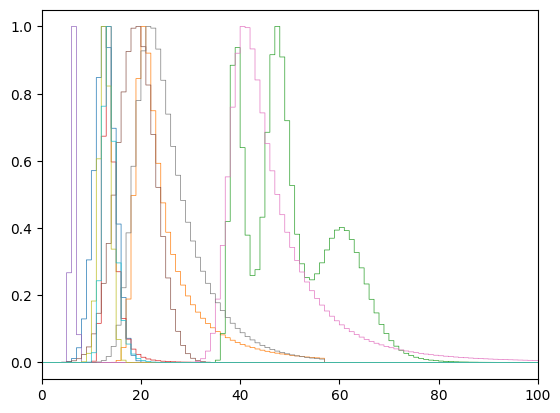

In [5]:
%matplotlib inline
for yd in padded_modelTimeSeries[30:40]:
    plt.plot(yd/np.max(yd), linewidth=.5, drawstyle="steps-post")
plt.xlim(0,100)